In [7]:
from os import cpu_count

from collections import OrderedDict
from typing import List, Tuple, Dict
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from torchinfo import summary

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cuda using PyTorch 2.2.1+cu121 and Flower 1.7.0


## Get Started With Federated Learning

In [8]:
# hyper-parameters

NUM_CLIENT = 10
EPOCHS_CLIENT = 1
BATCH_SIZE = 32
NUM_WORKER = cpu_count()

### Step 0: Loading Federated Dataset

In [9]:
### Loading The Federated Dataset ###

# first split (into train and test) and then you partition a specific split (train or test), ex: train split partitioned into 10 IID partitions

def load_fd_datasets(dataset_name: str):
    # loading a federated dataset
    federated_dataset = FederatedDataset(
        dataset=dataset_name, # ex: 'cifar10'
        # partitioners: in how many partitions you want your splits to be
        partitioners={'train': NUM_CLIENT}
        )

    # batch-wise transformation function
    def batch_transform(batch):
        img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        # transform batch data
        batch['img'] = [img_transform(img) for img in batch['img']]
        return batch
    
    # create train and val dataloaders
    train_dataloaders = []
    val_dataloaders = []

    # wrap partitions (Datasets) into torch Dataloaders
    for client_id in range(NUM_CLIENT):
        # load the partition specified by the idx in the selected split
        partition = federated_dataset.load_partition(node_id=client_id, split='train')
        # pass the tranform function
        partition = partition.with_transform(batch_transform)
        # now break the partition into train & val datasets
        partition = partition.train_test_split(train_size=0.8)
        # wrap with torch dataloader and add to dataloader list
        partition_train_dl = DataLoader(
            dataset=partition['train'],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKER
        )
        partition_val_dl = DataLoader(
            dataset=partition['test'],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKER
        )
        train_dataloaders.append(partition_train_dl)
        val_dataloaders.append(partition_val_dl)
        
    # create test dataloader from the test split (Dataset) with transform function
    test_data = federated_dataset.load_full(split='test').with_transform(batch_transform)
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER
    )

    # return all the train (partitioned), val (partitioned) & test dataloaders
    return train_dataloaders, val_dataloaders, test_dataloader

In [10]:
train_dataloaders, val_dataloaders, test_dataloader = load_fd_datasets(dataset_name='cifar10')

In [11]:
print(f'train batch size {len(train_dataloaders[0])}')
print(f'train dataset size {len(train_dataloaders[0].dataset)}')

print(f'val batch size {len(val_dataloaders[0])}')
print(f'val dataset size {len(val_dataloaders[0].dataset)}')

print(f'test batch size {len(test_dataloader)}')
print(f'test dataset size {len(test_dataloader.dataset)}')

train batch size 125
train dataset size 4000
val batch size 32
val dataset size 1000
test batch size 313
test dataset size 10000


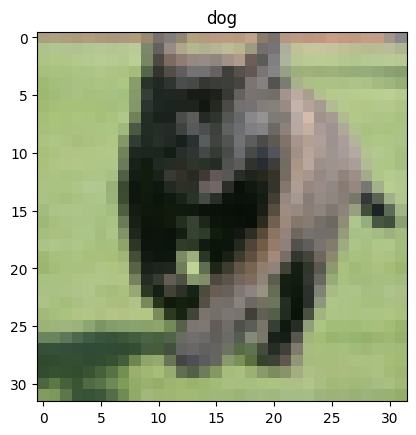

In [12]:
# plotting an image and label of the first train partition in train dataloader
batch = next(iter(train_dataloaders[0]))
img, y = batch['img'][0].permute(1, 2, 0), batch['label'][0].item()
# de-normalize image
img = img / 2 + 0.5
# get image label
label = train_dataloaders[0].dataset.features['label'].int2str(y)
# show image
plt.imshow(img)
plt.title(label)
plt.show()

### Step 1: Centralized Training With Pytorch

In [13]:
### Defining The Model ###

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture for 32*32 Image Data"""
        
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 10 * 8 * 8, out_features=10)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(self.block2(self.block1(x)))

# create the model
model = TinyVGG().to(DEVICE)
summary(model, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 10, 32, 32]           280
│    └─ReLU: 2-2                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 10, 32, 32]           910
│    └─ReLU: 2-4                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 10, 16, 16]           --
├─Sequential: 1-2                        [1, 10, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 10, 16, 16]           910
│    └─ReLU: 2-7                         [1, 10, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 10, 16, 16]           910
│    └─ReLU: 2-9                         [1, 10, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 10, 8, 8]             --
├─Sequentia

In [14]:
### Train and Test Function ###
### These function only work with FederatedDataset!!! (see batch loading is different) ###

# calculate accuracy
def accuracy_fn(y_pred: torch.tensor, y_true: torch.tensor) -> float:
    """Calculates the accuracy of a model on given predictions

    Args:
        y_pred: predicted labels
        y_true: true labels
    
    Returns:
        A float value which is the calculated accuracy.
    """
    return ((torch.eq(y_pred, y_true).sum().item() / len(y_true)) * 100)

# fit the model on training data
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy). For example:

        (0.1112, 0.8743)
    """
    train_loss, train_acc = 0, 0

    model.train() # model in train mode
    for batch in data_loader:
        # get data to device
        X = batch['img'].to(device)
        y = batch['label'].to(device)

        # forward pass
        y_logit = model(X)
        loss = loss_fn(y_logit, y)        

        # backward pass
        optimizer.zero_grad() # empty param's grad
        loss.backward() # backward propagation
        optimizer.step() # updata params (take the gradient descent step)

        # calculate loss and accuracy per batch
        train_loss += loss.item() * len(y)
        y_pred_labels = torch.argmax(y_logit, dim=1)
        train_acc += accuracy_fn(y_pred_labels, y)

    train_loss /= len(data_loader.dataset)
    train_acc /= len(data_loader)
    return (train_loss, train_acc)

# test the model on test data
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested.
        data_loader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A tuple of testing loss and testing accuracy metrics.
        In the form (test_loss, test_accuracy). For example:

        (0.0223, 0.8985)
    """

    test_loss , test_acc = 0, 0

    model.eval() # model in evaluation mode
    with torch.inference_mode():
        for batch in data_loader:
            # get data to device
            X = batch['img'].to(device)
            y = batch['label'].to(device)
            
            # forward pss
            y_logit = model(X)
            loss = loss_fn(y_logit, y)

            # calculate loss and accuracy per batch
            test_loss += loss.item() * len(y)
            y_pred_labels = torch.argmax(y_logit, dim=1)
            test_acc += accuracy_fn(y_pred_labels, y)

    test_loss /= len(data_loader.dataset)
    test_acc /= len(data_loader)
    return (test_loss, test_acc)

# complete training function for given epochs
def train_central(model: torch.nn.Module,
          train_dl: torch.utils.data.DataLoader,
          test_dl: torch.utils.data.DataLoader,
          epochs,
          device: torch.device,
          loss_fn: torch.nn.Module = None,
          optimizer: torch.optim.Optimizer = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dl: A DataLoader instance for the model to be trained on.
        test_dl: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        epochs: An integer indicating how many epochs to train for.

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
        For example if training for epochs=2: 
                    {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    
    result = {'Train_Loss': [],
            'Train_Acc': [],
            'Test_Loss': [],
            'Test_Acc': [],
            }
    
    # optimizer and criterion (loss_fn) if None given
    if loss_fn == None:
        loss_fn = torch.nn.CrossEntropyLoss()
    if optimizer == None:
        optimizer = torch.optim.Adam(model.parameters())

    for epoch in tqdm(range(epochs)):
        trainlss, trainacc = train_step(model, train_dl, loss_fn, optimizer, device)

        testlss, testacc = test_step(model, test_dl, loss_fn, device)

        print(f"Epoch {epoch} | Train Loss {trainlss:.4f} | Train Acc {trainacc:.2f} | Test Loss {testlss:.4f} | Test Acc {testacc:.2f}")

        result['Train_Loss'].append(trainlss)
        result['Train_Acc'].append(trainacc)
        result['Test_Loss'].append(testlss)
        result['Test_Acc'].append(testacc)
    
    return result

def eval_central(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         device: torch.device,
         loss_fn: torch.nn.Module = None) -> None:
    """
    function to evaluate the model on testing data

    Args:
        model (nn.Module): Model to fit the data.
        data_loader (DataLoader): Iterable over the dataset.
        loss_fn (nn.CrossEntropyLoss): Loss function.
        accuracy_fn (accuracy_fn): Optimizer for gradient update.
    Returns:
        None
    """

    eval_loss , eval_acc = 0, 0

    # criterion (loss_fn) if None given
    if loss_fn == None:
        loss_fn = torch.nn.CrossEntropyLoss()

    model.eval()
    with torch.inference_mode():
        for batch in data_loader:
            # get data to device
            X = batch['img'].to(device)
            y = batch['label'].to(device)

            # forward pass
            y_logit = model(X)
            loss = loss_fn(y_logit, y)

            # calculate loss and accuracy per batch
            eval_loss += loss.item()
            y_pred_labels = torch.argmax(y_logit, dim=1)
            eval_acc += accuracy_fn(y_pred_labels, y)

    eval_loss /= len(data_loader)
    eval_acc /= len(data_loader)
    
    result = {'model name': model.__class__.__name__,
              'model loss': round(eval_loss, ndigits=3),
              'model acc': round(eval_acc, ndigits=3)}
    return result

In [15]:
### Centralized Training and Evaluation

model = TinyVGG().to(DEVICE)
# optimizer = torch.optim.SGD(params=model.parameters())
# loss_fn = nn.CrossEntropyLoss()

# train
print(f"[INFO] training model")
result = train_central(model=model,
                train_dl=train_dataloaders[0],
                test_dl=val_dataloaders[0],
                device=DEVICE,
                epochs=5)

# eval
print(f"[INFO] evaluating model")
eval_central(model, test_dataloader, DEVICE)

[INFO] training model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train Loss 2.1663 | Train Acc 19.82 | Test Loss 1.9387 | Test Acc 28.32
Epoch 1 | Train Loss 1.8226 | Train Acc 34.12 | Test Loss 1.7615 | Test Acc 36.23
Epoch 2 | Train Loss 1.6548 | Train Acc 40.85 | Test Loss 1.6395 | Test Acc 42.19
Epoch 3 | Train Loss 1.5682 | Train Acc 44.90 | Test Loss 1.6535 | Test Acc 40.82
Epoch 4 | Train Loss 1.5051 | Train Acc 46.85 | Test Loss 1.6332 | Test Acc 42.38
[INFO] evaluating model


{'model name': 'TinyVGG', 'model loss': 1.621, 'model acc': 41.384}

### Step 2: Federated Learning With FLOWER

In [16]:
### Train and Test Function For FLOWER Clients
### Train and Test Function ###

# calculate accuracy
def accuracy_fn(y_pred: torch.tensor, y_true: torch.tensor) -> float:
    """Calculates the accuracy of a model on given predictions

    Args:
        y_pred: predicted labels
        y_true: true labels
    
    Returns:
        A float value which is the calculated accuracy.
    """
    return ((torch.eq(y_pred, y_true).sum().item() / len(y_true)) * 100)

# fit the model on training data
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          epochs: int,
          device: torch.device,
          verbose=False,
          loss_fn: torch.nn.Module = None,
          optimizer: torch.optim.Optimizer = None) -> Tuple[float, float]:
    """Trains a PyTorch model for the given epochs.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        epochs: Epochs.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        verbose: A boolean value to see the model metrics (loss and accuracy)
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
    
    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy). For example:

        (0.0223, 0.8985)
    """

    # optimizer and criterion (loss_fn) if None given
    if loss_fn == None:
        loss_fn = torch.nn.CrossEntropyLoss()
    if optimizer == None:
        optimizer = torch.optim.SGD(model.parameters())

    model.train() # model in train mode
    total_epoch_loss, total_epoch_acc = 0, 0
    for epoch in range(epochs):
        
        train_loss, train_acc = 0, 0
        
        for batch in data_loader:
            # get data to device
            X = batch['img'].to(device)
            y = batch['label'].to(device)

            # forward pass
            y_logit = model(X)
            loss = loss_fn(y_logit, y)        

            # backward pass
            optimizer.zero_grad() # empty param's grad
            loss.backward() # backward propagation
            optimizer.step() # updata params (take the gradient descent step)

            # Metrics
            # calculate loss and accuracy per batch
            train_loss += loss.item() * len(y)
            y_pred_labels = torch.argmax(y_logit, dim=1)
            train_acc += accuracy_fn(y_pred_labels, y)
        
        # per epoch
        train_loss /= len(data_loader.dataset)
        train_acc /= len(data_loader)
        
        if verbose:
            print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}")

        # for all epochs
        total_epoch_loss += train_loss
        total_epoch_acc += train_acc
    
    return (total_epoch_loss / epochs, total_epoch_acc / epochs)
    

# test the model on test data
def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         device: torch.device,
         loss_fn: torch.nn.Module=None) -> Tuple[float, float]:
    """Tests a PyTorch model for the given epochs.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested.
        data_loader: A DataLoader instance for the model to be tested on.
        device: A target device to compute on (e.g. "cuda" or "cpu").
        loss_fn: A PyTorch loss function to calculate loss on the test data.

    Returns:
        A tuple of testing loss and testing accuracy metrics.
        In the form (test_loss, test_accuracy). For example:

        (0.0223, 0.8985)
    """

    test_loss, test_acc = 0, 0

    # criterion (loss_fn) if None given
    if loss_fn == None:
        loss_fn = torch.nn.CrossEntropyLoss()

    model.eval() # model in evaluation mode
    with torch.inference_mode():
        for batch in data_loader:
            # get data to device
            X = batch['img'].to(device)
            y = batch['label'].to(device)
            
            # forward pss
            y_logit = model(X)
            loss = loss_fn(y_logit, y)

            # calculate loss and accuracy per batch
            test_loss += loss.item() * len(y)
            y_pred_labels = torch.argmax(y_logit, dim=1)
            test_acc += accuracy_fn(y_pred_labels, y)

    test_loss /= len(data_loader.dataset)
    test_acc /= len(data_loader)
    return (test_loss, test_acc)

In [17]:
### Updating Model Parameters (helper functions from client's perspective)

# set client paramters
def set_parameters(model: nn.Module, parameters: List[np.ndarray]):
    # de-serialize the ndarray to tensors
    parameters = [torch.from_numpy(np_arr).to(dtype=torch.float32, device=DEVICE) for np_arr in parameters]
    # match every weight with its model block
    param_dict = zip(model.state_dict().keys(), parameters)
    # convert the param_dict to ordered dict and load back into the model
    model.load_state_dict(OrderedDict(param_dict), strict=True)

# get parameters from client
def get_parameters(model: nn.Module) -> List[np.ndarray]:
    # serialize the model weights into ndarray and return
    return [weights.cpu().numpy() for _, weights in model.state_dict().items()]

In [18]:
### Implementing A FLOWER Client using NumPyClient

class CustomClient(fl.client.NumPyClient):
    """A custom client implementation representing an organization with model and data"""

    # pass a model, train and test dataloader
    def __init__(self, model, train_dataloader, val_dataloader) -> None:
        super().__init__()
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

    # return the current local model parameters to server
    def get_parameters(self, config):
        return get_parameters(self.model)
    
    # receive global model parameters, train and return the updated parameters with other metrics
    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        loss, accuracy = train(model=self.model, data_loader=self.train_dataloader, epochs=EPOCHS_CLIENT, device=DEVICE)
        return get_parameters(self.model), len(self.train_dataloader), {'loss': loss, 'accuracy': accuracy} # updated parameters, num_batches, metrics
    
    # receive global model parameters, evaluate and return the metrics
    def evaluate(self, parameters, config) -> Tuple[float | int | Dict[str, bool | bytes | float | int | str]]:
        set_parameters(self.model, parameters)
        loss, accuracy = test(model=self.model, data_loader=self.val_dataloader, device=DEVICE)
        return float(loss), len(self.val_dataloader), {'accuracy': accuracy} # loss, num_batches, metrics

In [19]:
### Using the Virtual Client Engine

# client_fun: To create CustomClient instance on demand when requested from FLOWER Framework

def client_fn(client_id: str) -> CustomClient:
    """Create a FLOWER client representing a single organization

    Creates an instance of CustomClient based on the client_id provided
    to load client specific data partition.

    Args:
        client_id: An str to load a specific client.

    Returns:
        A CustomClient (fl.client.NumPyClient) instance representing a FLOWER client.
    """

    # create an instance of the model
    model = TinyVGG().to(DEVICE)

    # load the client specific dataloaders
    train_dl = train_dataloaders[int(client_id)]
    val_dl = val_dataloaders[int(client_id)]

    # create client instance, convert object to Client type and return
    return CustomClient(model=model, train_dataloader=train_dl, val_dataloader=val_dl).to_client()

In [20]:
### Start The Training

# aggregate the metrics received from all the client's evaluate function
def eval_weighted_avg(metrics: List[Tuple[int, Metrics]]):
    #  multiply accuracy with each client's number of samples / or is it batch size??
    accuracies = [num_examples * m['accuracy'] for num_examples, m in metrics]
    num_samples = [num_examples for num_examples, _ in metrics]

    # aggregate and return the custom metrics (weighted avg)
    return {'test_accuracy': sum(accuracies) / sum(num_samples)}

# aggregate the metrics received from all the client's fit function
def fit_weighted_avg(metrics: List[Tuple[int, Metrics]]):
    #  multiply accuracy with each client's number of samples / or is it batch size??
    accuracies = [num_examples * m['accuracy'] for num_examples, m in metrics]
    num_samples = [num_examples for num_examples, _ in metrics]
    # for loss
    losses = [num_examples * m['loss'] for num_examples, m in metrics]

    # aggregate and return the custom metrics (weighted avg)
    return {'train_loss': sum(losses) / sum(num_samples), 'train_accuracy': sum(accuracies) / sum(num_samples)}

# pre-defined strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0, # C: fraction of client to choose for training
    fraction_evaluate=0.5, # fraction of client to choose for evaluation
    min_fit_clients=10, # minimum clients needed for training
    min_evaluate_clients=5, # minimum clients needed for evaluation
    min_available_clients=10, # wait till given client are available
    evaluate_metrics_aggregation_fn=eval_weighted_avg, # aggregate the metrics of clients
    fit_metrics_aggregation_fn=fit_weighted_avg, # aggregate the metrics of clients
)

# client resources (allocate cpus and gpus)
client_resources = {'num_cpus': NUM_WORKER//NUM_CLIENT, 'num_gpus': 1 if torch.cuda.is_available() else 0}

# start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENT,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources   
)

INFO flwr 2024-03-22 10:44:40,932 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-22 10:44:42,588	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-22 10:44:43,373 | app.py:213 | Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'object_store_memory': 7589041766.0, 'node:10.255.93.233': 1.0, 'memory': 15178083534.0}
INFO flwr 2024-03-22 10:44:43,373 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-22 10:44:43,373 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1}
INFO flwr 2024-03-22 10:44:43,379 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2024-03-22 10:44:43,379 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-22 10:44:43,380 | server.py:276 

History (loss, distributed):
	round 1: 2.3026082134246826
	round 2: 2.3030288074493406
	round 3: 2.3028984222412108
	round 4: 2.3029538326263426
	round 5: 2.302737197113037
History (metrics, distributed, fit):
{'train_loss': [(1, 2.3031972312927245), (2, 2.3031129083633424), (3, 2.303028942298889), (4, 2.302945051574707), (5, 2.302859384918213)], 'train_accuracy': [(1, 10.03), (2, 10.03), (3, 10.0075), (4, 10.0125), (5, 10.0025)]}History (metrics, distributed, evaluate):
{'test_accuracy': [(1, 10.15625), (2, 9.5703125), (3, 9.5703125), (4, 9.74609375), (5, 10.078125)]}